In [1]:
import pickle

import numpy as np
import yaml
from nuance import Nuance
from nuance.kernels import rotation
from nuance import utils

target = 100481123

gp_params = yaml.full_load(open(f"../data/{target}/gp.yaml", "r"))
data = pickle.load(open(f"../data/{target}/cleaned.fluxes", "rb"))
info = yaml.safe_load(open(f"../data/{target}/info.yaml", "r"))
periods = np.load(f"../data/{target}/periods.npy")

build_gp, _ = rotation()


/Users/lgarcia/code/dev/nuance/nuance/nuance.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
build_gp, _ = rotation()

gp = build_gp(gp_params, data["time"])
nu = Nuance(data["time"], data["flux"], gp=gp)

Ds = np.linspace(0.01, 0.03, 5)
# Ds = np.array([0.01, data["transit_duration"]])
nu.linear_search(data["time"], Ds)

search = nu.periodic_search(periods)

 52%|█████▏    | 665/1269 [00:10<00:09, 65.73it/s]

In [ ]:
import matplotlib.pyplot as plt
from nuance.utils import plot_search

plt.figure(figsize=(15, 5))
plot_search(nu, search)

In [ ]:
print(info["star_period"])
print(search.best)
print(search.best[-1]/info["star_period"])

0.84387471
[6.20428402 0.025      8.3647956 ]
9.912366729712673


In [ ]:
def index_binning(x, size):
    if isinstance(size, float):
        bins = np.arange(np.min(x), np.max(x), size)
    else:
        x = np.arange(0, len(x))
        bins = np.arange(0.0, len(x), size)

    d = np.digitize(x, bins)
    n = np.max(d) + 2
    indexes = []

    for i in range(0, n):
        s = np.where(d == i)
        if len(s[0]) > 0:
            s = s[0]
            indexes.append(s)

    return indexes

def binn_time(time, flux, bins=7/24/60):
    indexes = index_binning(time, bins)
    binned_time = np.array([np.mean(time[i]) for i in indexes])
    binned_flux = np.array([np.mean(flux[i]) for i in indexes])
    binned_error = np.array([np.std(flux[i])/np.sqrt(len(i)) for i in indexes])
    return binned_time, binned_flux, binned_error

In [25]:
from nuance.viz import *
from nuance.utils import phase, binn

def plot_search(nu, search, bins=7 / 60 / 24):
    """Plot result of a the periodic search

    Parameters
    ----------
    nu : _type_
        _description_
    search : _type_
        _description_
    """
    t0, D, P = search.best

    plt.subplot(2, 2, (1, 3))
    plt.plot(search.periods, search.Q_snr)
    plt.title(f"{P:.5f} days")

    mean, astro, noise = nu.models(t0, D, P)

    plt.subplot(2, 2, 2)
    plt.plot(nu.flux - mean, ".", c="0.8")
    plt.plot(astro, c="k", label="found")
    ylim = plt.ylim()
    _ = plt.legend()

    plt.subplot(2, 2, 4)
    mean, astro, noise = nu.models(t0, D, P)
    phi = phase(nu.time, t0, P)
    dphi = np.median(np.abs(np.diff(np.sort(phi))))
    detrended = nu.flux - noise - mean
    plt.plot(phi, detrended, ".", c=".8")
    bx, by, be = binn_time(phi, detrended, bins=bins)
    plt.errorbar(bx, by, yerr=be, fmt=".", c="k")
    plt.xlim(*(np.array([-1, 1]) * 10 * D))
    plt.ylim(*(np.array([-1, 1]) * float(np.abs(astro.min())) * 4))


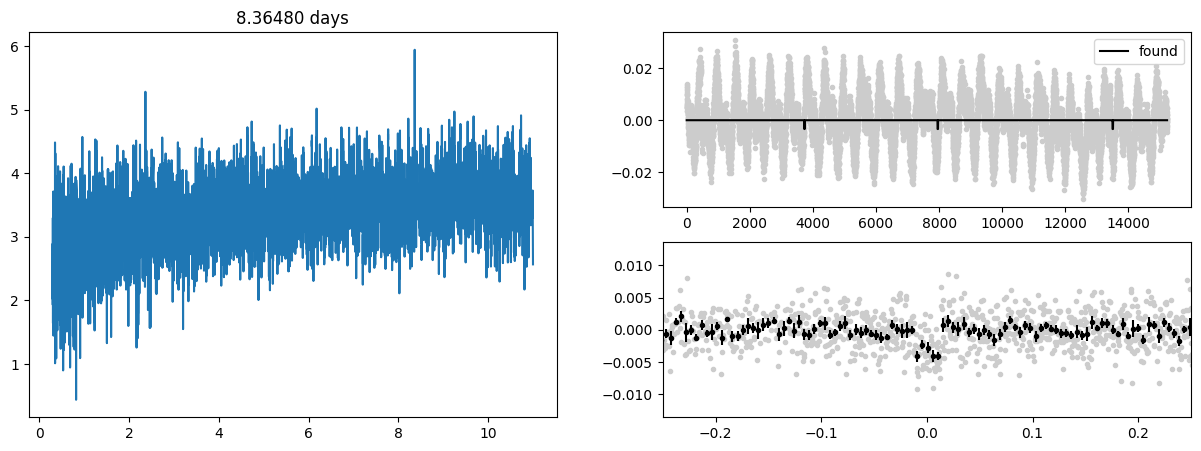

In [26]:
# from nuance.utils import plot_search
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plot_search(nu, search)

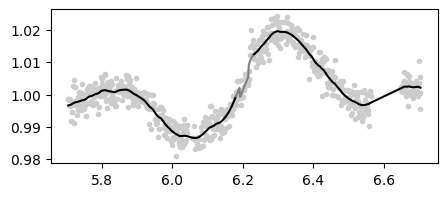

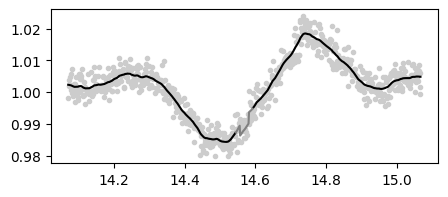

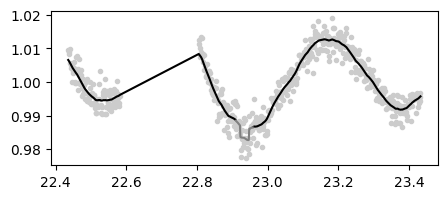

In [ ]:
from nuance import utils

t0, D, period = search.best
found_t0s = data["time"][np.flatnonzero(np.abs(utils.phase(data["time"], t0, period)) < 1/24/60)]
linear, astro, noise = nu.models(t0, D, period)

for t in found_t0s[0:5]:
    mask = np.abs(data["time"] - t) < 20*D
    transit_mask = np.abs(utils.phase(data["time"], t, period)) < D
    model_without_transit = np.array(linear + noise)
    model_without_transit[transit_mask] = np.nan
    model_with_transit = np.array(linear + noise + astro)
    model_with_transit[~transit_mask] = np.nan
    plt.figure(figsize=(5, 2))
    plt.plot(data["time"][mask], data["flux"][mask], ".", c="0.8")
    plt.plot(data["time"][mask], model_without_transit[mask], c="k")
    plt.plot(data["time"][mask], model_with_transit[mask], c="grey")

In [27]:
def bens_detrend(time, flux, n=5):
    def rotation_period(time, flux):
        """rotation period based on LS periodogram"""
        from astropy.stats import LombScargle

        ls = LombScargle(time, flux)
        frequency, power = ls.autopower(
            minimum_frequency=1/5, maximum_frequency=1 / 0.1
        )
        period = 1 / frequency[np.argmax(power)]
        return period

    def subtract_sinusoid(time, flux, period):
        X = np.vstack(
            [
                np.ones(len(time)),
                np.cos(2 * np.pi / period * time),
                np.sin(2 * np.pi / period * time),
            ]
        ).T

        w = np.linalg.lstsq(X, flux, rcond=None)[0]
        model = np.dot(X, w)

        return flux - model, model

    _flux = flux.copy()
    model = np.zeros_like(flux)

    for _ in range(n):
        period = rotation_period(time, _flux)
        _flux, _model = subtract_sinusoid(time, _flux, period)
        model += _model

    return _flux + 1.0, model

<ErrorbarContainer object of 3 artists>

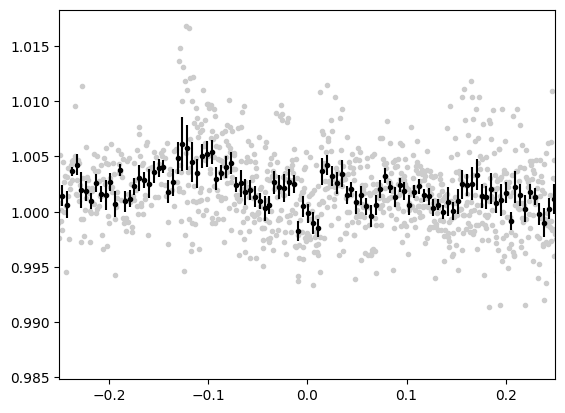

In [32]:
from nuance import utils
detrended_flux, model = bens_detrend(data["time"], data["flux"], 5)
# phase = utils.phase(data["time"], data["transit_t0"], data["planet_period"])
t0, duration, period = search.best
phase = utils.phase(data["time"], t0, period)

plt.plot(phase, detrended_flux, ".", c="0.8")
plt.xlim(*10*np.array([-1, 1])*duration)
bx, by, be = binn_time(phase, detrended_flux, bins=7/24/60)
plt.errorbar(bx, by, yerr=be, fmt=".", c="k")

In [ ]:
from nuance import utils
phase = utils.phase(data["time"], data["tra"])

plt.plot(phase, detrended_flux, ".", c="0.8")
bx, by = utils.binn(phase, detrended_flux, 50)
plt.plot(bx, by, ".", c="k")

In [ ]:
period

9.38142267783473

In [ ]:
˜transit_mask

SyntaxError: invalid character '˜' (U+02DC) (1698462828.py, line 1)

In [ ]:
utils.phase(data["time"], t0, period).min()

-0.40014370221563456

In [ ]:
data["planet_period"], data["planet_radius"]

(0.4, 2.5560519057944426)

In [ ]:
search.best

array([0.48446776, 0.02361885, 0.80028754])

In [ ]:
from nuance import utils

utils.clean_periods(periods, info["star_period"])

array([ 0.3       ,  0.30133767,  0.30267533, ..., 10.99732467,
       10.99866233, 11.        ])